In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from simpeg.utils import model_builder
from simpeg import maps

write_output = False

# sphinx_gallery_thumbnail_number = 2

In [3]:
# 1) Topografía
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)

x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

In [4]:
# 2) Malla
nx, ny, nz = 30, 30, 30
dx, dy, dz = 10.0, 10.0, 5.0

mesh = TensorMesh([[(dx, nx)], [(dy, ny)], [(dz, nz)]], "CCN")

# Activas bajo topografía
ind_active = active_from_xyz(mesh, xyz_topo)
nC = int(ind_active.sum())

# Centros SOLO activos (estos son los que guardamos)
cc_active = mesh.cell_centers[ind_active, :].astype(float)  # (nC,3)

# Índices geométricos (mismo “cuerpo” para ambas propiedades)
ind_block = (
    (cc_active[:, 0] > -50.0) & (cc_active[:, 0] < -20.0) &
    (cc_active[:, 1] > -15.0) & (cc_active[:, 1] <  15.0) &
    (cc_active[:, 2] < -50.0) & (cc_active[:, 2] > -70.0)
)

ind_sphere_all = model_builder.get_indices_sphere(
    np.r_[35.0, 0.0, -60.0], 14.0, mesh.cell_centers
)
ind_sphere = ind_sphere_all[ind_active]  # esfera restringida a celdas activas

In [5]:
# 3) Propiedad 1: Contraste de densidad (Grav)
background_density = 0.0
block_density      = -0.2
sphere_density     = 0.2

Grav_model = background_density * np.ones(nC, dtype=float)
Grav_model[ind_block]  = block_density
Grav_model[ind_sphere] = sphere_density

# 4) Propiedad 2: Susceptibilidad (Mag)
background_susc = 0.0
block_susc      = 0.008
sphere_susc     = 0.01

Mag_model = background_susc * np.ones(nC, dtype=float)
Mag_model[ind_block]  = block_susc
Mag_model[ind_sphere] = sphere_susc

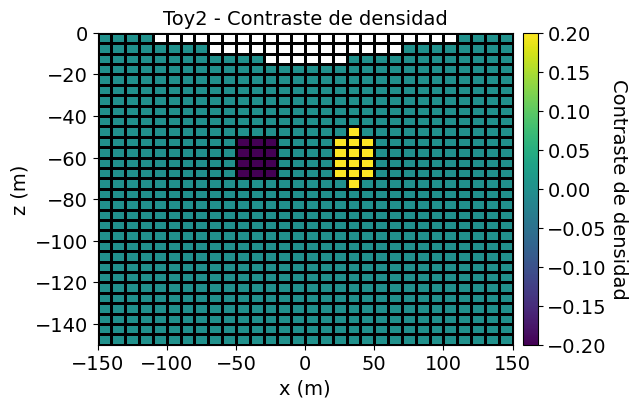

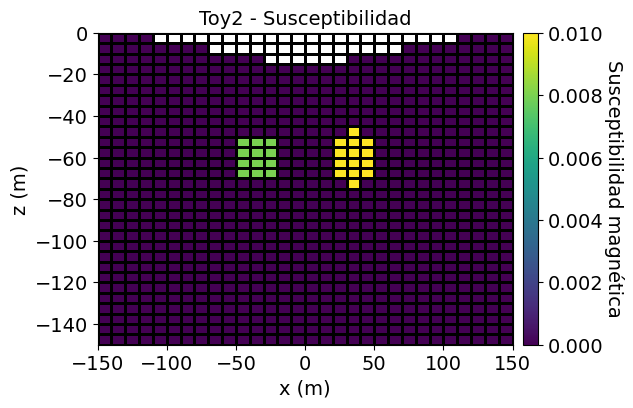

In [6]:
# 5) Plots (opcional)
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

def plot_slice(model_active, title, cbar_label):
    fig = plt.figure(figsize=(5, 4))
    ax1 = fig.add_axes([0.1, 0.12, 0.83, 0.78])

    mesh.plot_slice(
        plotting_map * model_active,
        normal="Y",
        ax=ax1,
        ind=int(mesh.shape_cells[1] / 2),
        grid=True,
        clim=(np.nanmin(model_active), np.nanmax(model_active)),
    )

    ax1.set_title(title, size=14)
    ax1.set_xlabel("x (m)", size=14)
    ax1.set_ylabel("z (m)", size=14)
    ax1.tick_params(axis="both", labelsize=14)

    ax2 = fig.add_axes([0.95, 0.12, 0.03, 0.78])
    norm = mpl.colors.Normalize(vmin=np.nanmin(model_active), vmax=np.nanmax(model_active))
    cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
    cbar.set_label(cbar_label, rotation=270, labelpad=15, size=14)
    cbar.ax.tick_params(labelsize=14)

    plt.show()

plot_slice(Grav_model, "Toy2 - Contraste de densidad", "Contraste de densidad")
plot_slice(Mag_model,  "Toy2 - Susceptibilidad",       "Susceptibilidad magnética")

In [7]:
# 6) Guardar NPZ
np.savez(
    "Toy2_Grav.npz",
    Grav_model=Grav_model,         # (nC,)
    cell_centers=cc_active,        # (nC,3)
    dx=float(dx), dy=float(dy), dz=float(dz),
)

np.savez(
    "Toy2_Mag.npz",
    Mag_model=Mag_model,           # (nC,)
    cell_centers=cc_active,        # (nC,3)
    dx=float(dx), dy=float(dy), dz=float(dz),
)

print("Guardado: Toy2_Grav.npz y Toy2_Mag.npz")
print("nC activas:", nC)
print("Grav_model:", Grav_model.shape, " | cell_centers:", cc_active.shape)
print("Mag_model :", Mag_model.shape,  " | cell_centers:", cc_active.shape)

Guardado: Toy2_Grav.npz y Toy2_Mag.npz
nC activas: 26462
Grav_model: (26462,)  | cell_centers: (26462, 3)
Mag_model : (26462,)  | cell_centers: (26462, 3)
